Postprocessing of experimental data

I_fft_values (imaginary part): [ 0.00000000e+00  6.22612771e+01 -1.34301115e+02 ...  4.41921280e-02
  2.07280135e-02 -2.81433821e-02]
U_fft_values (imaginary part): [ 0.00000000e+00  3.58386803e+01 -8.36497852e+00 ...  1.67087304e-02
 -2.22098377e-02  1.27686583e-02]


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


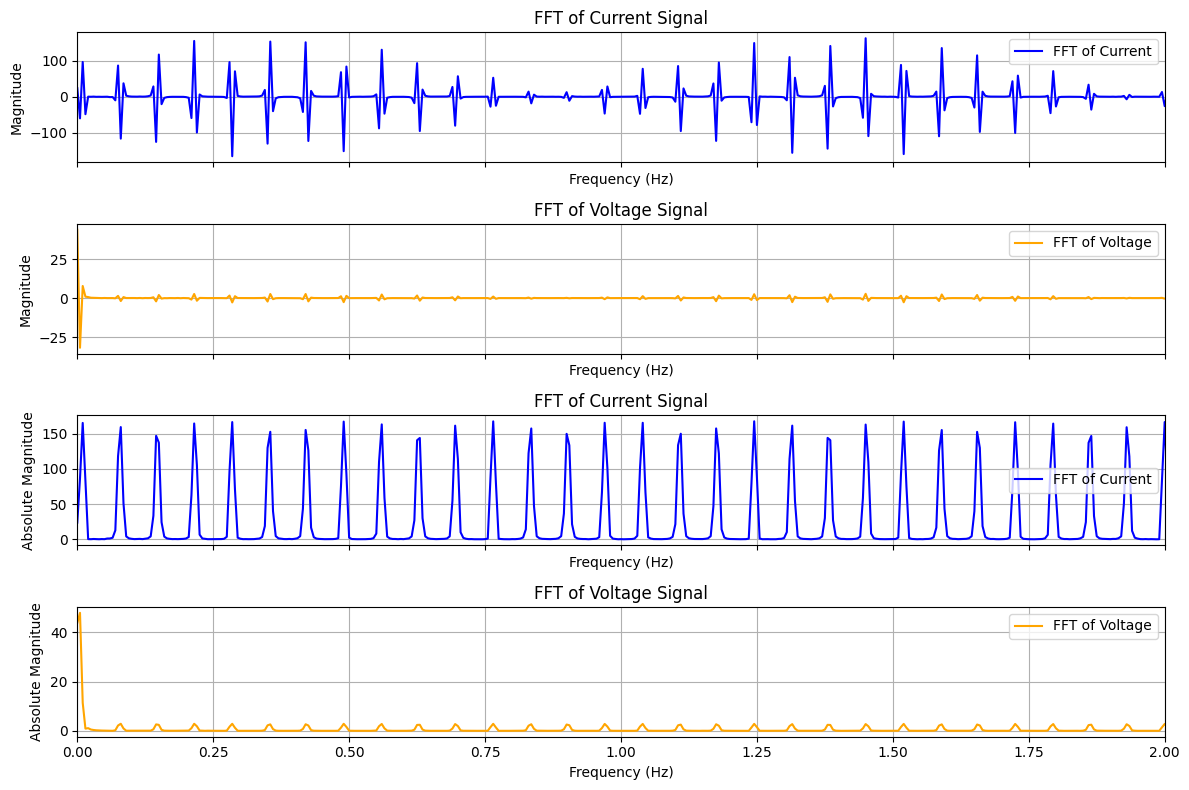

In [68]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal.windows import hann
from scipy.fft import fft, fftfreq
# for debugging mainly
import matplotlib.pyplot as plt

# ----------------------------
# User parameters
# ----------------------------
cell_capacity_Ah = 3.5       # Ah
window_size_s = 200          # seconds
fs = 200                    # Hz (sampling frequency) (supposedly 1000 Hz, but the data is actually sampled at 200 Hz)
f_pass = 1e-3                # Hz (high-pass filter cutoff)
frequencies = np.logspace(np.log10(0.01), np.log10(2), 30)  # injected f_n
hp_order = 3                 # high-pass filter order

# ----------------------------
# Load BaSyTec exported CSV
# ----------------------------
# CSV must have columns: 'time_s', 'current_A', 'voltage_V'
df = pd.read_csv("LowRes/Joshua_CCSM_lowRes_S50_001_3pt45to3pt8.txt", sep='\t', encoding='unicode_escape')
# Note: unicode_escape is used to handle special characters in the CSV file, such that special characters like 'ï' are read correctly as a string.
t = df['~Time[s]'].to_numpy()
I_raw = df['I[A]'].to_numpy()
U_raw = df['U[V]'].to_numpy()

# ----------------------------
# Plot raw data
# ----------------------------
# plt.figure(figsize=(12, 6))
# plt.plot(t, I_raw, label='Raw Current', color='blue')
# plt.plot(t, U_raw, label='Raw Voltage', color='orange')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Raw Current and Voltage Signals')
# plt.legend()
# plt.grid()
# plt.show()

# ----------------------------
# Trim data
# ----------------------------
mask_beginning = t >= 20  # Start trimming from 20 seconds
mask_ending = t <= 2000  # End trimming at 2000 seconds (because for some reason the charge stops after 3.8 despite limit being 4.2)
t = t[mask_beginning & mask_ending]
I_raw = I_raw[mask_beginning & mask_ending]
U_raw = U_raw[mask_beginning & mask_ending]



# ----------------------------
# Plot the trimmed raw data
# ----------------------------

# Plot current on the left y-axis

# fig, ax1 = plt.subplots(figsize=(12, 6))
# ax1.plot(t, I_raw, label='Raw Input Current (I)', color='blue')
# ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Current (A)', color='blue')
# ax1.legend(loc='upper left')
# ax1.tick_params(axis='y', labelcolor='blue')

# # Create a second y-axis for voltage
# ax2 = ax1.twinx()
# ax2.plot(t, U_raw, label='Raw Output Voltage (V)', color='orange')
# ax2.set_ylabel('Voltage (V)', color='orange')
# ax2.legend(loc='upper right')
# ax2.tick_params(axis='y', labelcolor='orange')

# # Title and grid
# plt.title('Raw Current and Voltage Signals')
# fig.tight_layout()
# plt.grid(True)

# plt.show()


# ----------------------------
# Preprocess data
# ----------------------------
# High-pass filter the raw current and voltage data
def highpass_filter(data, fs, f_pass, order):
    nyquist = 0.5 * fs
    normal_cutoff = f_pass / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

I_filtered = highpass_filter(I_raw, fs, f_pass, hp_order)
U_filtered = highpass_filter(U_raw, fs, f_pass, hp_order)
# ----------------------------
# Windowing
# ----------------------------
# Create a Hann window
window_size = int(window_size_s * fs)  # Convert seconds to samples
hann_window = hann(window_size)
# Apply the window to the filtered current and voltage data
I_windowed = I_filtered[:window_size] * hann_window
U_windowed = U_filtered[:window_size] * hann_window
# ----------------------------
# FFT
# ----------------------------
# Compute FFT of the windowed data
def compute_fft(data, fs):  
    N = len(data)
    fft_values = np.fft.fft(data) # or use scipy.fft.fft(data)
    fft_freqs = np.fft.fftfreq(N, 1/fs) # or use scipy.fft.fftfreq(N, 1/fs)
    # return fft_freqs[:N//2], np.abs(fft_values[:N//2]) ## no absolute!!
    return fft_freqs[:N//2], fft_values[:N//2] ## no absolute!!

def compute_abs_fft(data, fs):  
    N = len(data)
    fft_values = np.fft.fft(data) # or use scipy.fft.fft(data)
    fft_freqs = np.fft.fftfreq(N, 1/fs) # or use scipy.fft.fftfreq(N, 1/fs)
    return fft_freqs[:N//2], np.abs(fft_values[:N//2]) #//2 be

I_fft_freqs, I_fft_values = compute_fft(I_windowed, fs)
U_fft_freqs, U_fft_values = compute_fft(U_windowed, fs)

I_fft_freqs, I_fft_abs_values = compute_abs_fft(I_windowed, fs)
U_fft_freqs, U_fft_abs_values = compute_abs_fft(U_windowed, fs)

# print imaginary parts of the FFT results
print("I_fft_values (imaginary part):", I_fft_values.imag)
print("U_fft_values (imaginary part):", U_fft_values.imag)
# returned
# I_fft_values (imaginary part): [0. 0. 0. ... 0. 0. 0.]
# U_fft_values (imaginary part): [0. 0. 0. ... 0. 0. 0.]
# ----------------------------
# Plotting the FFT results
# ----------------------------
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True) 
# 4.1 Plotting FFT of current
axs[0].plot(I_fft_freqs, I_fft_values, label='FFT of Current', color='blue')
axs[0].set_ylabel('Magnitude')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_title('FFT of Current Signal')
axs[0].legend()
axs[0].set_xlim(0, 2)  # Limit x-axis to 10 Hz for better visibility
axs[0].grid()
# 4.2 Plotting FFT of voltage
axs[1].plot(U_fft_freqs, U_fft_values, label='FFT of Voltage', color='orange')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude')
axs[1].set_title('FFT of Voltage Signal')
axs[1].legend()
axs[1].set_xlim(0, 2)  # Limit x-axis to 10 Hz for better visibility
axs[1].grid()

axs[2].plot(I_fft_freqs, I_fft_abs_values, label='FFT of Current', color='blue')
axs[2].set_ylabel('Absolute Magnitude')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_title('FFT of Current Signal')
axs[2].legend()
axs[2].set_xlim(0, 2)  # Limit x-axis to 10 Hz for better visibility
axs[2].grid()
# 4.2 Plotting FFT of voltage
axs[3].plot(U_fft_freqs, U_fft_abs_values, label='FFT of Voltage', color='orange')
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('Absolute Magnitude')
axs[3].set_title('FFT of Voltage Signal')
axs[3].legend()
axs[3].set_xlim(0, 2)  # Limit x-axis to 10 Hz for better visibility
axs[3].grid()
plt.tight_layout()
plt.show()
# ----------------------------

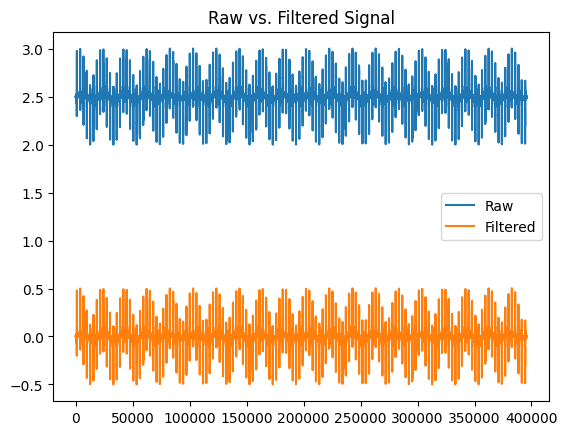

I_raw [2.49492333 2.4936164  2.4936164  ... 2.50145796 2.50211143 2.50015104]
I_filtered [-0.00297469 -0.00428164 -0.00428165 ...  0.00391874  0.00457227
  0.00261194]


In [ ]:
'''
    Debugging code: 
    shows how the raw and filtered signals look like; the high pass filter filters out the DC bias.
'''

plt.figure()
plt.plot(I_raw, label='Raw')
plt.plot(I_filtered, label='Filtered')
plt.legend()
plt.title('Raw vs. Filtered Signal')
plt.show()
print("I_raw", I_raw)
print("I_filtered", I_filtered)

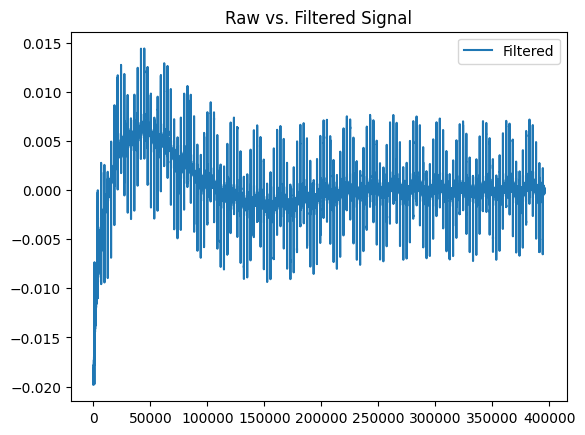

In [37]:
'''
    Debugging code: 
    shows how the raw and filtered voltage signals look like; the high pass filter filters out the DC bias.
'''
plt.figure()
# plt.plot(U_raw, label='Raw')
plt.plot(U_filtered, label='Filtered')
plt.legend()
plt.title('Raw vs. Filtered Signal')
plt.show()

I_fft_freqs [0.0000e+00 5.0000e-03 1.0000e-02 ... 9.9985e+01 9.9990e+01 9.9995e+01]


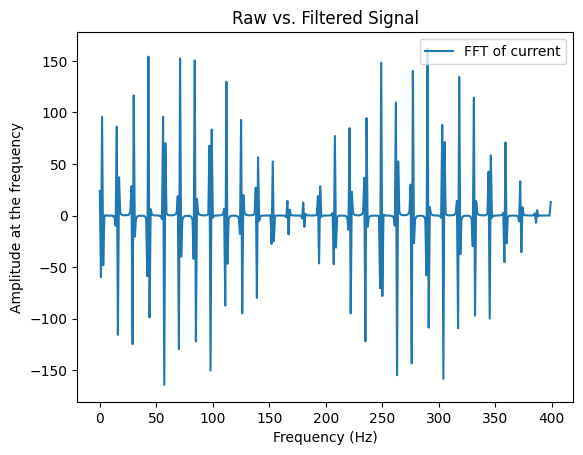

In [78]:
'''
    Debugging code: 
    shows the post-fft results of the current signal.
'''
print("I_fft_freqs", I_fft_freqs)
plt.figure()
plt.plot(I_fft_values[:400], label='FFT of current')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude at the frequency')
plt.legend()
plt.title('Raw vs. Filtered Signal')
plt.show()

In [2]:
# np.isinf(U_fft_values).any()
print(np.any(~np.isfinite(I_fft_values)))  # Check if there are any non-finite values in the FFT results
print(I_fft_values.shape)
print(I_fft_values.dtype)

print(np.any(~np.isfinite(U_fft_values)))  # Check if there are any non-finite values in the FFT results
print(U_fft_values.shape)
print(U_fft_values.dtype)


False
(20000,)
complex128
False
(20000,)
complex128


In [3]:
import control as ct

# Define the transfer function
# Example: G(s) = (s + 1) / (s^2 + 2s + 2)
U_fft_values_noNaN = np.nan_to_num(U_fft_values)  # Ensure no NaN values
I_fft_values_noNaN = np.nan_to_num(I_fft_values)  # Ensure no NaN values
sys = ct.TransferFunction(U_fft_values_noNaN, I_fft_values_noNaN)

# Plot the Nyquist diagram
plt.figure()
ct.nyquist_plot(sys)

# Customize the plot (optional)
plt.title('Nyquist Plot of G(s)')
plt.xlabel('Real Axis')
plt.ylabel('Imaginary Axis')
plt.grid(True)

# Show the plot
plt.show()

TypeError: unsupported data type: <class 'numpy.complex128'>

[-0.02084312 -0.00186464 -0.00202373 ... -0.01723266 -0.04364594
 -0.10415021]


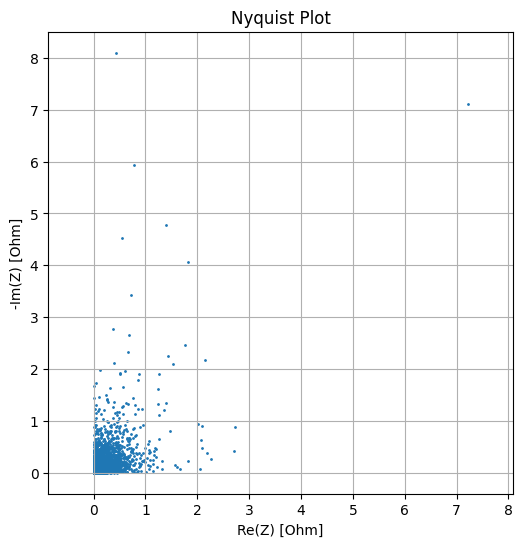

In [54]:
# Compute impedance at each frequency
Z = U_fft_values / I_fft_values
# filter out negative real parts and positive imaginary parts 
Z = Z[(Z.real > 0) & (Z.imag < 0)]

# Nyquist plot: Imaginary vs Real part of Z
plt.figure(figsize=(6, 6))
print(Z.imag)

plt.scatter(Z.real, -Z.imag, s =1)  # Nyquist: Im(Z) is plotted negative y
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Im(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.grid(True)
plt.axis('equal')
plt.show()

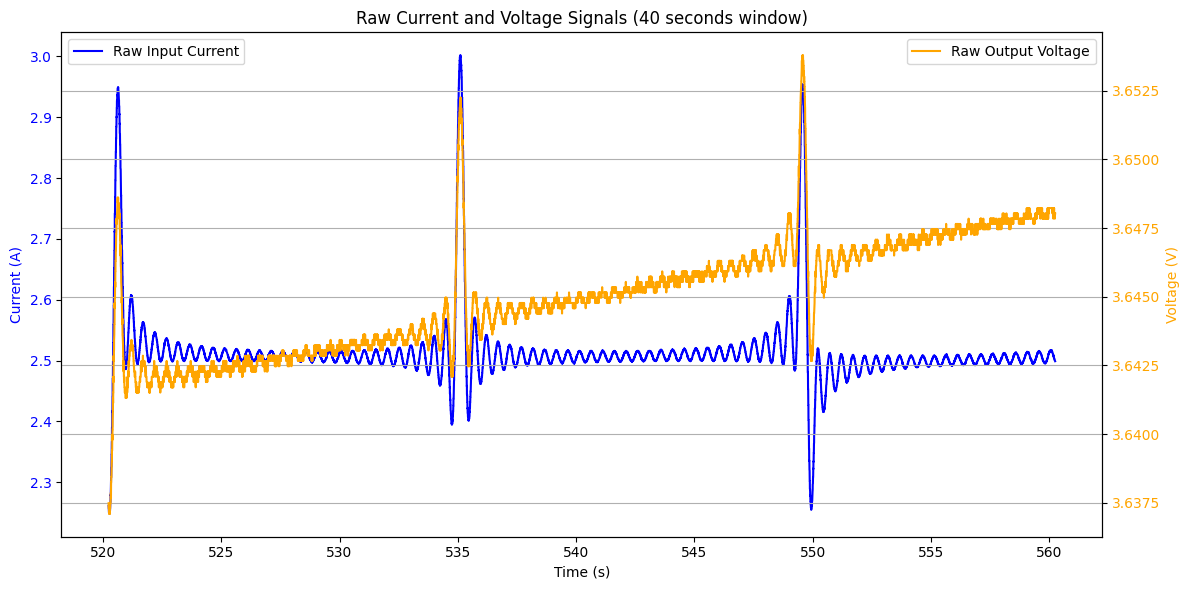

In [ ]:
### Plotting with a window of 200 seconds
window_size_s = 40  # seconds
window_size_samples = int(window_size_s * fs)  # Convert window size to samples

fig, ax1 = plt.subplots(figsize=(12, 6))

start_time = 500
start_index = start_time * fs

# Plot current on the left y-axis
ax1.plot(t[start_index: start_index + window_size_samples], I_raw[start_index: start_index + window_size_samples], label='Raw Input Current', color='blue')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Current (A)', color='blue')
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for voltage
ax2 = ax1.twinx()
ax2.plot(t[start_index: start_index + window_size_samples], U_raw[start_index: start_index + window_size_samples], label='Raw Output Voltage', color='orange')
ax2.set_ylabel('Voltage (V)', color='orange')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and grid
plt.title('Raw Current and Voltage Signals (40 seconds window)')
fig.tight_layout()
plt.grid(True)

plt.show()

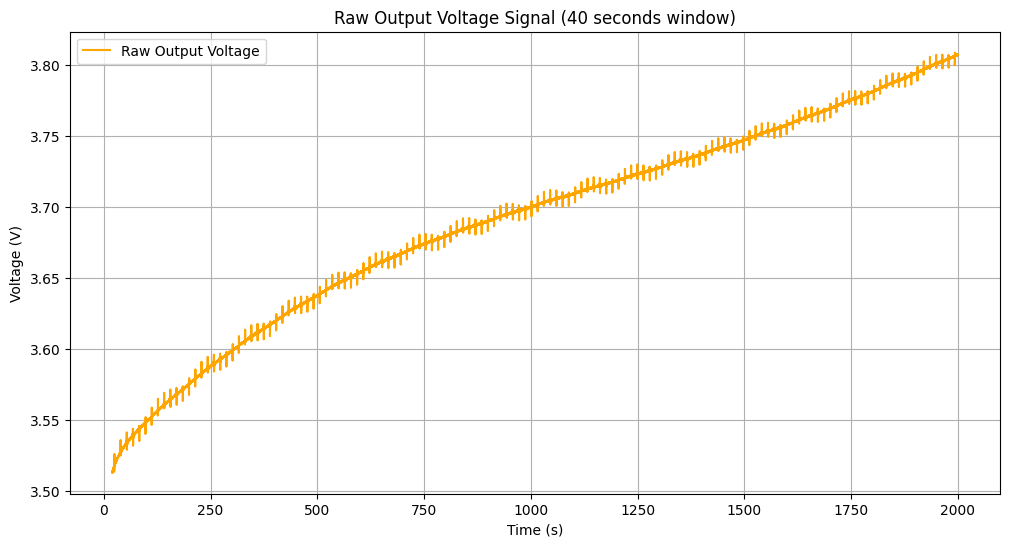

In [ ]:
# Plotting only the voltage response
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, U_raw,label='Raw Output Voltage', color='orange')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend()
ax.set_title('Raw Output Voltage Signal (40 seconds window)')
plt.grid()
plt.show()

In [ ]:
# testing random signal FFT
import numpy as np
t = np.linspace(0, 1, 512, endpoint=False)
signal = np.sin(2*np.pi*50*t) + 0.5*np.sin(2*np.pi*120*t)
fft_vals = np.fft.fft(signal)
print("Imaginary part:", fft_vals.imag)  # Should NOT be all zeros

Imaginary part: [ 0.00000000e+00 -7.35538646e-14 -6.73905376e-14  4.93247952e-14
  2.83524562e-14  3.43732599e-14  3.84137167e-14 -6.40741894e-14
  8.03801470e-14  7.90344644e-14 -2.93967306e-13  1.04618053e-13
 -9.96361969e-14 -8.65889423e-14  9.94759830e-14  8.53653070e-14
 -2.36337509e-14  7.78245706e-15  2.06768335e-13 -4.14323387e-13
  3.73416845e-14 -5.13978542e-13  2.03699360e-13  2.74822251e-14
 -6.07333169e-14  1.28274713e-13  7.70530804e-14 -3.32553130e-13
 -5.14294956e-14 -4.53118999e-13  4.98608189e-14 -1.38702839e-14
 -6.29619992e-14  6.64491360e-14 -4.76423631e-14 -2.51413410e-14
  3.15989161e-14 -4.20552851e-14  2.20884210e-14  9.50791701e-15
 -3.52173915e-14 -4.96845688e-14 -1.53987862e-13 -6.45081002e-14
  5.97366611e-14 -2.23291165e-14 -7.90481772e-14  2.70290211e-14
  1.79146271e-13 -3.74150171e-13 -2.56000000e+02 -2.06104918e-13
  1.44801984e-13  1.02299044e-13  3.16491249e-14  6.45264713e-14
  9.68114477e-14 -3.36519404e-14  6.94103012e-14  1.97184498e-13
 -5.66574